In [36]:
#pip install cvxpy numpy

# Readme

This notebook exemplifies the results of [1, Section 3.3] (and in particular those of [1, Proposition 3.16]) for the numerical analysis of extragradient and optimistic method).

> [1] Anne Rubbens, Julien M. Hendrickx, Adrien Taylor. "A constructive approach to strengthen algebraic descriptions of function and operator classes."


In [13]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time

## Example: Optimistic Gradient

In this example, we aim to obtain a bound on $\frac{\|t(x_K)\|^2}{\|x_0-x_\star\|}$, 

valid for all operator $t$ that is $L$-Lipschitz and monotone, 

and such that $y_0=x_0$, and

>$ y_k = x_k-\gamma t(y_{k-1}), \ k>0,$

>$ x_{k+1}=x_k-\gamma t(y_k), \ k\geq 0 $

This bound can be compared with [2,Theorem 4.4]:

>$\frac{\|t(x_K)\|^2}{\|x_0-x_\star\|}\leq \frac{123L^2}{K+32}$

>[2] Eduard Gorbunov, Adrien Taylor, Gauthier Gidel. "Last-iterate convergence of optimistic gradient method for monotone variational inequalities"

We rely on several descriptions of $L-Lipschitz monotone operators:

> Naive description $A_{ij}=\|t_i-t_j\|^2-L^2\|x_i-x_j\|^2$, and $B_{ij}=-2L\langle t_i-t_j,x_i-x_j\rangle$.

>Refined description: $\forall \lambda_k, \mu_i, \mu_j\geq 0$: $0\geq \lambda_k(\mu_i+\mu_j)(A_{ik}\mu_i+A_{jk}\mu_j)-\lambda_k \mu_i\mu_j A_{ij}+\lambda_k^2 (B_{ik} \mu_i+B_{jk}\mu_j)+B_{ij} \mu_i\mu_j(\mu_i+\mu_j)$ and $ 0\geq \lambda_k(\mu_i+\mu_j)(B_{ik}\mu_i+B_{jk}\mu_j)-\lambda_k \mu_i\mu_j B_{ij}+\lambda_k^2 (A_{ik} \mu_i+A_{jk}\mu_j)+A_{ij} \mu_i\mu_j(\mu_i+\mu_j)$.

In [14]:
def wc_optimistic_Gradient_NaiveOperator(L,K,gamma,verbose):

    dimG = 2 * (K + 1)
    nbPts = 2 * (K + 1)

    # SDP variable G=P^TP, P=[x_0, t_0,...t_K]
    G = cp.Variable((dimG, dimG), symmetric=True)
    constraints = [G >> 0]
    
    #Construction of xbar,tbar: xbar(i)'*G*xbar(i)=xi^2, tbar(i)'*G*tbar(i)=ti^2

    xbar = np.zeros((dimG, 2 * (K + 1) - 1))
    tbar = np.zeros((dimG, 2 * (K + 1) - 1))

    xbar[0, 0] = 1
    tbar[1:, :] = np.eye(2 * (K + 1) - 1)

    #Optimistic Gradient
    xbar[:, 1] = xbar[:, 0] - gamma * tbar[:, 0]
    xbar[:, 2] = xbar[:, 0] - gamma * tbar[:, 1]

    for i in range(3, 2 * K + 1, 2):
        xbar[:, i] = xbar[:, i - 1] - gamma * tbar[:, i - 2]
        xbar[:, i + 1] = xbar[:, i - 1] - gamma * tbar[:, i]
    
    #Addition of optimal point, 0 wlog
    xs = np.zeros((dimG, 1))
    ts = np.zeros((dimG, 1))
    XX = np.concatenate([xs, xbar], axis=1)
    GG = np.concatenate([ts, tbar], axis=1)
    
    # Initial condition on ||x0-xs||^2
    constraints += [cp.quad_form(xbar[:, 0], G) <= 1]

    # Interpolation constraints
    for i in range(nbPts):
        for j in range(i+1,nbPts):
                xi, ti = XX[:, i:i+1], GG[:, i:i+1]
                xj, tj = XX[:, j:j+1], GG[:, j:j+1]

                constraints += [cp.quad_form(tj - ti, G) <= L * cp.quad_form(xi - xj, G)]
                constraints += [-(ti - tj).T @ G @ (xi - xj) <= 0]

    # Objective: ||t_k||^2
    obj = cp.quad_form(GG[:, -1], G)

    # Solve
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(verbose=verbose)

    a = obj.value
    
    return a

In [15]:
def wc_optimistic_Gradient_RefinedOperator(L,K,gamma,verbose):

    dimG = 2 * (K + 1)
    nbPts = 2 * (K + 1)

    # SDP variable G=P^TP, P=[x_0, t_0,...t_K]
    G = cp.Variable((dimG, dimG), symmetric=True)
    constraints = [G >> 0]
    
    #Construction of xbar,tbar: xbar(i)'*G*xbar(i)=xi^2, tbar(i)'*G*tbar(i)=ti^2

    xbar = np.zeros((dimG, 2 * (K + 1) - 1))
    tbar = np.zeros((dimG, 2 * (K + 1) - 1))

    xbar[0, 0] = 1
    tbar[1:, :] = np.eye(2 * (K + 1) - 1)

    #Optimistic Gradient
    xbar[:, 1] = xbar[:, 0] - gamma * tbar[:, 0]
    xbar[:, 2] = xbar[:, 0] - gamma * tbar[:, 1]

    for i in range(3, 2 * K + 1, 2):
        xbar[:, i] = xbar[:, i - 1] - gamma * tbar[:, i - 2]
        xbar[:, i + 1] = xbar[:, i - 1] - gamma * tbar[:, i]
    
    #Addition of optimal point, 0 wlog
    xs = np.zeros((dimG, 1))
    ts = np.zeros((dimG, 1))
    XX = np.concatenate([xs, xbar], axis=1)
    GG = np.concatenate([ts, tbar], axis=1)
    
    # Initial condition on ||x0-xs||^2
    constraints += [cp.quad_form(xbar[:, 0], G) <= 1]

    # Interpolation constraints
    for i in range(nbPts):
        for j in range(i+1,nbPts):
                xi, ti = XX[:, i:i+1], GG[:, i:i+1]
                xj, tj = XX[:, j:j+1], GG[:, j:j+1]

                constraints += [cp.quad_form(tj - ti, G) <= L * cp.quad_form(xi - xj, G)]
                constraints += [-(ti - tj).T @ G @ (xi - xj) <= 0]

                for k in range(i+1,nbPts):
                    if k != i and k != j:
                        xk, tk = XX[:, k:k+1], GG[:, k:k+1]

                        # Create auxiliary 7x7 SDP matrix
                        G1 = cp.Variable((7, 7), symmetric=True)
                        constraints += [G1 >> 0]

                        Bij = -2*L * (xi - xj).T @ G @ (ti - tj)
                        Aij = (ti - tj).T @ G @ (ti - tj) - L**2*(xi - xj).T @ G @ (xi - xj)

                        Bik = -2 * (xi - xk).T @ G @ (ti - tk)
                        Aik = (ti - tk).T @ G @ (ti - tk) - L**2* (xi - xk).T @ G @ (xi - xk)

                        Bjk = -2 * (xk - xj).T @ G @ (tk - tj)
                        Ajk = (tk - tj).T @ G @ (tk - tj) - L**2*(xk - xj).T @ G @ (xk - xj)

                        # Add G1 constraints
                        constraints += [
                            G1[0, 0] == -Bij,
                            G1[0, 1] == 0,
                            G1[1, 1] == -Ajk,
                            G1[0, 2] == 0,
                            G1[0, 4] + G1[1, 2] == 0,
                            G1[0, 3] + G1[1, 4] == 0,
                            G1[1, 3] == 0,
                            G1[2, 2] == -Bij,
                            G1[0, 5] + G1[2, 4] == 0,
                            2 * G1[0, 6] + 2 * G1[1, 5] + 2 * G1[2, 3] + G1[4, 4] == Aij - Aik - Ajk,
                            G1[1, 6] + G1[3, 4] == 0,
                            G1[3, 3] == -Bjk,
                            G1[2, 5] == 0,
                            G1[2, 6] + G1[4, 5] == 0,
                            G1[3, 5] + G1[4, 6] == 0,
                            G1[3, 6] == 0,
                            G1[5, 5] == -Aik,
                            G1[5, 6] == 0,
                            G1[6, 6] == -Bik
                        ]

    # Objective: ||t_k||^2
    obj = cp.quad_form(GG[:, -1], G)

    # Solve
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(verbose=verbose)

    a = obj.value
    
    return a

In [11]:
L, gamma, K = 1, 5/31, 3

pepit_tau_naive = wc_optimistic_Gradient_NaiveOperator(L,K,gamma,False)
pepit_tau_improved = wc_optimistic_Gradient_RefinedOperator(L,K,gamma,False)

print('*** Optimistic Gradient *** ')
print('\tExisting guarantee:\t ||t(x_(K))||^2_2 <= {:.6} ||x0-x*||^2_2'.format(123*L**2/(K+32)))
print('\tPEPit guarantee (std inequalities):\t ||t(x_(K))||^2_2 <= {:.6} ||x0-x*||^2_2'.format(pepit_tau_naive))
print('\tPEPit guarantee (refined inequalities):\t ||t(x_(K))||^2_2 <= {:.6}  ||x0-x*||^2_2'.format(pepit_tau_improved))
print('\tIs the refined inequality stronger? {}'.format(pepit_tau_improved<=pepit_tau_naive))

*** Optimistic Gradient *** 
	Existing guarantee:	 ||t(x_(K))||^2_2 <= 34.3231 ||x0-x*||^2_2
	PEPit guarantee (std inequalities):	 ||t(x_(K))||^2_2 <= 0.926029 ||x0-x*||^2_2
	PEPit guarantee (refined inequalities):	 ||t(x_(K))||^2_2 <= 0.923335  ||x0-x*||^2_2
	Is the refined inequality stronger? True


### Experiments for a few numbers of iterations

In [ ]:
K_list = np.array([1,2,3,5,7])

L,  gamma = 1, 5/31

OG_Operator_Naive = list()
OG_Operator_Improved = list()

for K in K_list:
    t0= time.process_time()
    pepit_tau_naive = wc_optimistic_Gradient_NaiveOperator(L, K, gamma, False)
    OG_Operator_Naive.append(pepit_tau_naive)
    pepit_tau_improved = wc_optimistic_Gradient_RefinedOperator(L, K, gamma, False)
    OG_Operator_Improved.append(pepit_tau_improved)
    t1 = time.process_time() - t0
    print('K=',K,' done [elapsed time:',"%.2f" %t1,'[s]')

K= 1  done [elapsed time: 0.36 [s]
K= 2  done [elapsed time: 2.62 [s]
K= 3  done [elapsed time: 21.66 [s]


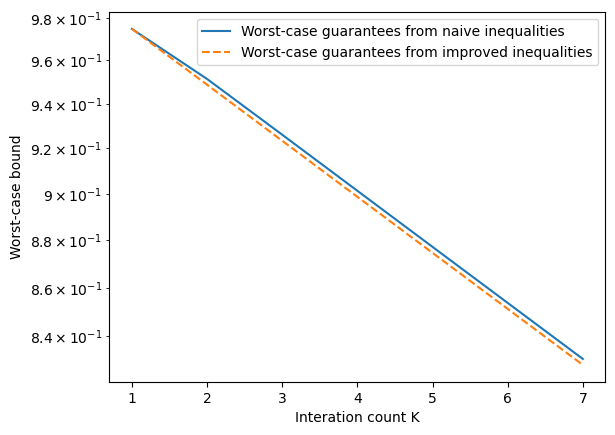

In [63]:
# Plots
plt.plot(K_list, OG_Operator_Naive, '-', label='Worst-case guarantees from naive inequalities')
plt.plot(K_list, OG_Operator_Improved, '--', label='Worst-case guarantees from improved inequalities')

plt.legend()
plt.xlabel('Interation count K')
plt.ylabel('Worst-case bound')
plt.semilogy()

plt.show()

## Example: Extra Gradient

In this example, we aim to obtain a bound on $\frac{\|t(x_K)\|^2}{\|x_0-x_\star\|}$, 

valid for all operator $t$ that is $L$-Lipschitz and monotone, 

and such that

>$ y_{k+1} = x_k-\gamma t(x_{k}), \ k\geq 0,$

>$ x_{k+1}=x_k-\gamma t(y_{k+1}), \ k\geq 0 $

This bound can be compared with [3,Theorem 3.3]:

>$\frac{\|t(x_K)\|^2}{\|x_0-x_\star\|}\leq \frac{1}{\gamma^2(1-L^2\gamma^2)(K+1)}$

>[3] Eduard Gorbunov, Nicolas Loizou, Gauthier Gidel. "Extragradient method: O (1/k) last-iterate convergence for monotone variational inequalities and connections with cocoercivity"

We rely on several descriptions of $L-Lipschitz monotone operators:

> Naive description $A_{ij}=\|t_i-t_j\|^2-L^2\|x_i-x_j\|^2$, and $B_{ij}=-2L\langle t_i-t_j,x_i-x_j\rangle$.

>Refined description: $\forall \lambda_k, \mu_i, \mu_j\geq 0$: $0\geq \lambda_k(\mu_i+\mu_j)(A_{ik}\mu_i+A_{jk}\mu_j)-\lambda_k \mu_i\mu_j A_{ij}+\lambda_k^2 (B_{ik} \mu_i+B_{jk}\mu_j)+B_{ij} \mu_i\mu_j(\mu_i+\mu_j)$ and $ 0\geq \lambda_k(\mu_i+\mu_j)(B_{ik}\mu_i+B_{jk}\mu_j)-\lambda_k \mu_i\mu_j B_{ij}+\lambda_k^2 (A_{ik} \mu_i+A_{jk}\mu_j)+A_{ij} \mu_i\mu_j(\mu_i+\mu_j)$.

In [55]:
def wc_Extra_Gradient_NaiveOperator(L,K,gamma,verbose):

    dimG = 2 * (K + 1)
    nbPts = 2 * (K + 1)

    # SDP variable G=P^TP, P=[x_0, t_0,...t_K]
    G = cp.Variable((dimG, dimG), symmetric=True)
    constraints = [G >> 0]
    
    #Construction of xbar,tbar: xbar(i)'*G*xbar(i)=xi^2, tbar(i)'*G*tbar(i)=ti^2

    xbar = np.zeros((dimG, 2 * (K + 1) - 1))
    tbar = np.zeros((dimG, 2 * (K + 1) - 1))

    xbar[0, 0] = 1
    tbar[1:, :] = np.eye(2 * (K + 1) - 1)

    #Extra Gradient
    for i in range(1, 2 * K + 1, 2):
        xbar[:, i] = xbar[:, i-1] - gamma * tbar[:, i-1]
        xbar[:, i + 1] = xbar[:, i-1] - gamma * tbar[:, i]
    
    #Addition of optimal point, 0 wlog
    xs = np.zeros((dimG, 1))
    ts = np.zeros((dimG, 1))
    XX = np.concatenate([xs, xbar], axis=1)
    GG = np.concatenate([ts, tbar], axis=1)
    
    # Initial condition on ||x0-xs||^2
    constraints += [cp.quad_form(xbar[:, 0], G) <= 1]

    # Interpolation constraints
    for i in range(nbPts):
        for j in range(nbPts):
            if i != j:
                xi, ti = XX[:, i:i+1], GG[:, i:i+1]
                xj, tj = XX[:, j:j+1], GG[:, j:j+1]

                constraints += [cp.quad_form(tj - ti, G) <= L * cp.quad_form(xi - xj, G)]
                constraints += [-(ti - tj).T @ G @ (xi - xj) <= 0]

    # Objective: ||t_k||^2
    obj = cp.quad_form(GG[:, -1], G)

    # Solve
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(verbose=verbose)

    a = obj.value
    
    return a

In [56]:
def wc_Extra_Gradient_RefinedOperator(L,K,gamma,verbose):

    dimG = 2 * (K + 1)
    nbPts = 2 * (K + 1)

    # SDP variable G=P^TP, P=[x_0, t_0,...t_K]
    G = cp.Variable((dimG, dimG), symmetric=True)
    constraints = [G >> 0]
    
    #Construction of xbar,tbar: xbar(i)'*G*xbar(i)=xi^2, tbar(i)'*G*tbar(i)=ti^2

    xbar = np.zeros((dimG, 2 * (K + 1) - 1))
    tbar = np.zeros((dimG, 2 * (K + 1) - 1))

    xbar[0, 0] = 1
    tbar[1:, :] = np.eye(2 * (K + 1) - 1)

    #Extra Gradient
    for i in range(1, 2 * K + 1, 2):
        xbar[:, i] = xbar[:, i-1] - gamma * tbar[:, i-1]
        xbar[:, i + 1] = xbar[:, i-1] - gamma * tbar[:, i]
    
    #Addition of optimal point, 0 wlog
    xs = np.zeros((dimG, 1))
    ts = np.zeros((dimG, 1))
    XX = np.concatenate([xs, xbar], axis=1)
    GG = np.concatenate([ts, tbar], axis=1)
    
    # Initial condition on ||x0-xs||^2
    constraints += [cp.quad_form(xbar[:, 0], G) <= 1]

    # Interpolation constraints
    for i in range(nbPts):
        for j in range(nbPts):
            if i != j:
                xi, ti = XX[:, i:i+1], GG[:, i:i+1]
                xj, tj = XX[:, j:j+1], GG[:, j:j+1]

                constraints += [cp.quad_form(tj - ti, G) <= L * cp.quad_form(xi - xj, G)]
                constraints += [-(ti - tj).T @ G @ (xi - xj) <= 0]

                for k in range(nbPts):
                    if k != i and k != j:
                        xk, tk = XX[:, k:k+1], GG[:, k:k+1]

                        # Create auxiliary 7x7 SDP matrix
                        G1 = cp.Variable((7, 7), symmetric=True)
                        constraints += [G1 >> 0]

                        Bij = -2*L * (xi - xj).T @ G @ (ti - tj)
                        Aij = (ti - tj).T @ G @ (ti - tj) - L**2*(xi - xj).T @ G @ (xi - xj)

                        Bik = -2 * (xi - xk).T @ G @ (ti - tk)
                        Aik = (ti - tk).T @ G @ (ti - tk) - L**2* (xi - xk).T @ G @ (xi - xk)

                        Bjk = -2 * (xk - xj).T @ G @ (tk - tj)
                        Ajk = (tk - tj).T @ G @ (tk - tj) - L**2*(xk - xj).T @ G @ (xk - xj)

                        # Add G1 constraints
                        constraints += [
                            G1[0, 0] == -Bij,
                            G1[0, 1] == 0,
                            G1[1, 1] == -Ajk,
                            G1[0, 2] == 0,
                            G1[0, 4] + G1[1, 2] == 0,
                            G1[0, 3] + G1[1, 4] == 0,
                            G1[1, 3] == 0,
                            G1[2, 2] == -Bij,
                            G1[0, 5] + G1[2, 4] == 0,
                            2 * G1[0, 6] + 2 * G1[1, 5] + 2 * G1[2, 3] + G1[4, 4] == Aij - Aik - Ajk,
                            G1[1, 6] + G1[3, 4] == 0,
                            G1[3, 3] == -Bjk,
                            G1[2, 5] == 0,
                            G1[2, 6] + G1[4, 5] == 0,
                            G1[3, 5] + G1[4, 6] == 0,
                            G1[3, 6] == 0,
                            G1[5, 5] == -Aik,
                            G1[5, 6] == 0,
                            G1[6, 6] == -Bik
                        ]

    # Objective: ||t_k||^2
    obj = cp.quad_form(GG[:, -1], G)

    # Solve
    prob = cp.Problem(cp.Maximize(obj), constraints)
    prob.solve(verbose=verbose)

    a = obj.value
    
    return a

In [57]:
L, gamma, K = 1, 1/2**0.5, 3

pepit_tau_naive = wc_Extra_Gradient_NaiveOperator(L,K,gamma,False)
pepit_tau_improved = wc_Extra_Gradient_RefinedOperator(L,K,gamma,False)

print('*** Extra Gradient *** ')
print('\tExisting guarantee:\t ||t(x_(K))||^2_2 <= {:.6} ||x0-x*||^2_2'.format(1/gamma**2/(1-L**2*gamma**2)/(K+1)))
print('\tPEPit guarantee (std inequalities):\t ||t(x_(K))||^2_2 <= {:.6} ||x0-x*||^2_2'.format(pepit_tau_naive))
print('\tPEPit guarantee (refined inequalities):\t ||t(x_(K))||^2_2 <= {:.6}  ||x0-x*||^2_2'.format(pepit_tau_improved))
print('\tIs the refined inequality stronger? {}'.format(pepit_tau_improved<=pepit_tau_naive))

*** Extra Gradient *** 
	Existing guarantee:	 ||t(x_(K))||^2_2 <= 1.0 ||x0-x*||^2_2
	PEPit guarantee (std inequalities):	 ||t(x_(K))||^2_2 <= 0.438954 ||x0-x*||^2_2
	PEPit guarantee (refined inequalities):	 ||t(x_(K))||^2_2 <= 0.431199  ||x0-x*||^2_2
	Is the refined inequality stronger? True


In [60]:
K_list = np.array([1,2,3,5,7])

L,  gamma = 1,  1/2**0.5

EG_Operator_Naive = list()
EG_Operator_Improved = list()

for K in K_list:
    t0= time.process_time()
    pepit_tau_naive = wc_Extra_Gradient_NaiveOperator(L, K, gamma, False)
    EG_Operator_Naive.append(pepit_tau_naive)
    pepit_tau_improved = wc_Extra_Gradient_RefinedOperator(L, K, gamma, False)
    EG_Operator_Improved.append(pepit_tau_improved)
    t1 = time.process_time() - t0
    print('K=',K,' done [elapsed time:',"%.2f" %t1,'[s]')


K= 1  done [elapsed time: 0.56 [s]
K= 2  done [elapsed time: 4.44 [s]
K= 3  done [elapsed time: 17.56 [s]
K= 5  done [elapsed time: 227.62 [s]
K= 7  done [elapsed time: 2293.77 [s]


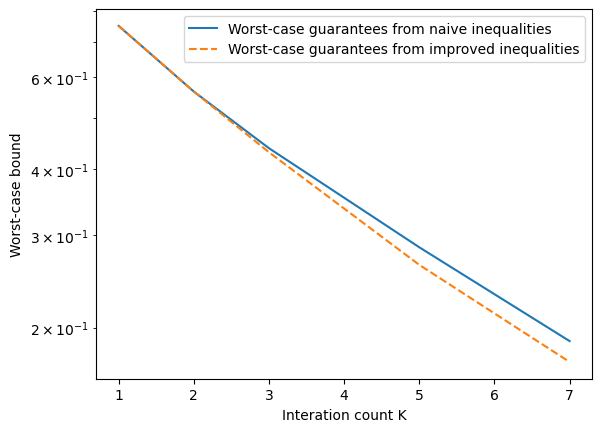

In [73]:
# Plots
plt.plot(K_list, EG_Operator_Naive, '-', label='Worst-case guarantees from naive inequalities')
plt.plot(K_list, EG_Operator_Improved, '--', label='Worst-case guarantees from improved inequalities')

plt.legend()
plt.xlabel('Interation count K')
plt.ylabel('Worst-case bound')
plt.semilogy()

plt.show()